In [92]:
# from qiskit.opflow import I, Z, X, Y, SparsePauliOp
import numpy as np
# from juices import Juices
# 假设有 3 台机器和 3 个操作
m = 3 # 机器数量
N = 2 # 表示机器的二进制 (0, 1)
n = 2 # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3, 100],[3, 1, 2, 100]])

# 非法数组(用于表示机器数)(1, 1)
b = np.array([[0, 0],[1, 0] ,[0, 1], [1, 1]])
bw = np.array([[1, 1]])
# 常数
K1 = 10
P = 5

# 量子比特数量
num_qubits = n * N + l

In [93]:
from qiskit import QuantumCircuit

def append_multi_rzz_term(qc, qubits, gamma, N):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    
    参数:
    qc: QuantumCircuit 对象
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    gamma: float，RZ 旋转的角度
    """
    control_qubits = qubits[:N-1]
    # print(control_qubits)
    target_qubit = qubits[N-1:]
    # print(target_qubit)
    n_controls = len(control_qubits)
    if n_controls == 1:
        qc.cx(control_qubits[0],target_qubit[0])
    else:
        # ancilla_qubit = n_controls - 2
        qc.mcx(control_qubits, target_qubit[0])
    qc.rz(gamma, target_qubit[0])
    if n_controls == 1:
        qc.cx(control_qubits[0], target_qubit[0])
    else:
        qc.mcx(control_qubits, target_qubit[0])

# # 示例使用
# n = 4  # 例如4个量子比特，其中3个为控制，1个为目标
# qc = QuantumCircuit(n)
# control_qubits = [0, 1, 2]  # 第0、1、2个为控制位
# target_qubit = 3            # 第3个为目标位
# gamma = 0.5                 # 旋转角度
# 
# append_multi_rzz_term(qc, control_qubits, target_qubit, gamma)
# 
# # 输出电路
# qc.draw('mpl')

In [94]:
def append__zz_term( qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)

def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)
def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [95]:
def get_cost_circuit1(gamma, n, N, l, K1, P, p, qc, bw):
    for h in range(l):
        coef = - 2**h
        append__z_term(qc, N * n + h, coef * gamma)
    return qc

In [96]:
def get_cost_circuit2(gamma, n, N, l, K1, P, p, qc, bw):
    for j in range(len(bw)):
        for i in range (n):
            constant = 1
            qubits_index = np.array([], dtype=int)
            for k in range (N):
                constant = constant*(1/2*(1+(1-2*bw[j,k])))
                qubits_index = np.append(qubits_index, i * N + k)
            append_multi_rzz_term(qc, qubits_index, 2 * K1 * constant * gamma, N)
                
    return qc

In [97]:
def get_cost_circuit3(gamma, n, N, l, K1, P, p, qc, b):
    for j in range(len(b)):
        for i1 in range (n):
            for i2 in range(n): 
                if i1 != i2:
                    constant1 = p[i1, j] * p[i2, j]
                    constant2 = 1
                    qubits_index = np.array([], dtype=int)
                    for k in range (N):
                        constant2 = constant2* (1/2*(1+(1-2*b[j,k])))**2
                        qubits_index = np.append(qubits_index, i1 * N + k)
                        qubits_index = np.append(qubits_index, i2 * N + k)
                    constant = constant1*constant2
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma, N)
        for i in range(n):
            constant1 = - (2**l-1) * p[i, j]
            constant2 = 1
            qubits_index = np.array([], dtype=int)
            for k in range(N):
                constant2 = constant2*(1/2*(1+(1-2*b[j,k])))
                qubits_index = np.append(qubits_index, i * N + k)
            constant = constant1 * constant2
            append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma, N)
        for i in range(n):
            constant1 = p[i, j]
            constant2 = 1
            qubits_index = np.array([], dtype=int)
            for k in range (N):
                constant2 = constant2 * (1/2*(1+(1-2*b[j,k])))**2
                qubits_index = np.append(qubits_index, i * N + k)
            for h in range(l):
                constant3 = 2 ** h
                qubits_index = np.append(qubits_index, n * N + h)
                constant = constant1 * constant2 * constant3
                append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma, N)
        for h1 in range(l):
            for h2 in range(l):
                qubits_index = np.array([], dtype=int)
                if h1 != h2:
                    qubits_index = np.append(qubits_index, n * N + h1)
                    qubits_index = np.append(qubits_index, n * N + h2)
                    constant = 2 ** h1 * 2 ** h2 * P
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant * gamma, N)
                

In [98]:
def get_mixer_circuit(beta, n, N, l, K1, P, p, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

In [99]:
def invert_counts(s):
    return s[::-1]

In [100]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import Aer, transpile, assemble, QuantumCircuit, execute


# 定义成本函数
def cost_function(params, n, N, l, K1, P, p, bw):
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length  = len(params)
    for i in range(int(length/2)):

        get_cost_circuit1(gamma[i], n, N, l, K1, P, p, qc, bw)
        get_cost_circuit2(gamma[i], n, N, l, K1, P, p, qc, bw)
        get_cost_circuit3(gamma[i], n, N, l, K1, P, p, qc, b)
        get_mixer_circuit(beta[i], n, N, l, K1, P, p, qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n*N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n*N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range (n):
                constant = 1
                for k in range (N):
                    constant = constant*(1-(s_ik[i,k]-bw[j,k])**2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2*(1-(s_ik[i,k]-b[j,k])**2)
                constant1 += p[i,j]*constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            E3 += P * (constant1 - constant3)
        
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        
        E =  E1 + E2 + E3
        
        expectation += E * prob

    return expectation, counts

In [101]:
from qiskit_algorithms.optimizers import COBYLA

# 优化 QAOA 参数
def optimize_qaoa(n, N, l, K1, P, p, params, bw):
    def objective(params):
        expectation, _ = cost_function(params, n, N, l, K1, P, p, bw)

        return expectation

    optimizer = COBYLA(rhobeg = 1.5, tol = 1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [102]:
import time

# 运行优化
# p_max = 6  # 最大层数

startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(30):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0,  2 * np.pi)
        if k >0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        # 创建参数向量
        # print("init_point_temp"+ init_point_temp)
        result = optimize_qaoa(n, N, l, K1, P, p, init_point_temp, bw)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x, n, N, l, K1, P, p, bw)
        # 寻找这20对点中最优的参数
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 2 层   第 0 个参数
第： 2 层   第 1 个参数
第： 2 层   第 2 个参数
第： 2 层   第 3 个参数
第： 2 层   第 4 个参数
第： 2 层   第 5 个参数
第： 2 层   第 6 个参数
第： 2 层   第 7 个参数
第： 2 层   第 8 个参数
第： 2 层   第 9 个参数
第： 2 层   第 10 个参数
第： 2 层   第 11 个参数
第： 2 层   第 12 个参数
第： 2 层   第 13 个参数
第： 2 层   第 14 个参数
第： 2 层   第 15 个参数
第： 2 层   第 16 个参数
第： 2 层   第 17 个参数
第： 2 层   第 18 个参数
第： 2 层   第 19 个参数
第： 2 层   第 20 个参数
第： 2 层   第 21 个参数
第： 2 层   第 22 个参数
第： 2 层   第 23 个参数
第： 2 层   第 24 个参数
第： 2 层   第 25 个参数
第： 2 层   第 2

优化时间： 267.9083330631256
Optimal parameters: [9.90144328 4.07570887 1.87328633 3.39476034 1.09298397 2.54565717]
Optimal value: 5.9510000000000005
Final expectation value: 5.9510000000000005
Final measurement counts: {'11111': 1002, '00011': 980, '11101': 965, '01011': 953, '00001': 953, '10111': 930, '10101': 928, '01001': 879, '11011': 328, '11001': 327, '01111': 319, '10001': 295, '00101': 294, '00111': 289, '10011': 280, '01101': 278}


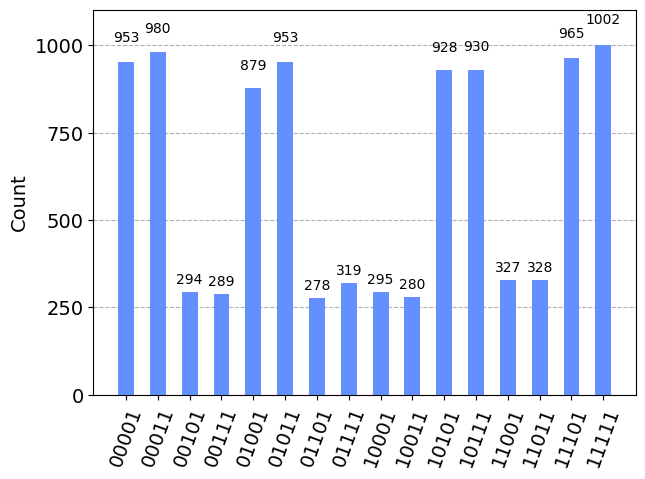

In [103]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x, n, N, l, K1, P, p, bw)
# sorted_dict = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)